# Incorporating the importance metric into results

In [31]:
import pandas as pd
import numpy as np
import copy
from sklearn.metrics import average_precision_score, roc_auc_score

from collections import defaultdict

from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

from pathlib import Path
import json

## Importance (features) from the future for a selected timestamp

In [2]:
all_scores_decaying_df_dict = pd.read_pickle(
    '../benchmark_data/10_eval_ml_models/diff_pos_neg_edges_cuis_2016_2023_all_models_scores_dict.pkl'
)

In [3]:
importance_experiment_pairs_year = ('2016','2017')

In [4]:
benchmark_importance_metrics_df = pd.read_pickle(
    '../benchmark_data/09_benchmark_feature_collection/benchmark_importance_metrics_df.pkl'
)

In [6]:
benchmark_models_scores_df = all_scores_decaying_df_dict[importance_experiment_pairs_year]

benchmark_models_scores_df['cui_pair'] = (
      benchmark_models_scores_df['subj'] 
    + ' '
    + benchmark_models_scores_df['obj']
)

In [5]:
benchmark_importance_metrics_df

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent
0,C0033308__progesterone,C1421999__SLC38A1 gene,C0033308,C1421999,C0033308 C1421999,1,27.0,0.005632,0.004669,0.345337,-0.001702,0.000000e+00
1,C0557874__Global developmental delay,C0152423__Congenital small ears,C0557874,C0152423,C0152423 C0557874,1,39.0,0.006297,0.105121,0.542392,0.000053,9.112312e-09
2,C1332733__CDK2 gene,C1332650__C-Terminal Binding Protein 1,C1332733,C1332650,C1332650 C1332733,1,6.0,0.016198,0.049270,0.600761,-0.000063,1.621441e-06
3,C0006142__Malignant neoplasm of breast,C1136328__Iridoids,C0006142,C1136328,C0006142 C1136328,2,48.0,0.006355,0.000272,0.028818,0.002889,0.000000e+00
4,C1456409__etravirine,C4045491__doravirine,C1456409,C4045491,C1456409 C4045491,15,239.0,0.016966,0.030973,0.140814,-0.000003,1.250633e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
48563,"C1448177__TNF protein, human",C1824798__CRTC1 gene,C1448177,C1824798,C1448177 C1824798,1,64.0,0.008860,0.011995,0.405616,0.004581,0.000000e+00
48564,C1332803__CTNNB1 gene,C1835953__NOTUM gene,C1332803,C1835953,C1332803 C1835953,4,147.0,0.031855,0.013270,0.105266,0.000367,1.700016e-06
48565,C0002335__alprostadil,C0008864__citrulline,C0002335,C0008864,C0002335 C0008864,0,14.0,0.000446,0.068027,0.512115,-0.000111,5.522397e-08
48566,C1363984__TNFRSF1A gene,C2350562__Brominated Diphenyl Ethers,C1363984,C2350562,C1363984 C2350562,0,4.0,0.002455,0.010173,0.334290,-0.000046,1.520694e-05


## Calculating merged importance metric

In [6]:
benchmark_importance_metrics_df['jac_2nd_neg_train'] = - benchmark_importance_metrics_df['jac_2nd_train']

In [7]:
imp_metric_columns = [
    'ig',
    'eig_cent_diff',
    'betw_cent',
    'jac_2nd_neg_train',
    'mentions_diff',
    'sem_scholar_cit',
]

In [9]:
power = 1

benchmark_importance_metrics_df['IMP_manh'] = (
    benchmark_importance_metrics_df
        [imp_metric_columns]
        .rank(axis=0, pct=True, method='average').apply( # ties have the same rank value
            lambda x: (
                sum(
                    [abs(x[k])**power for k in x.keys()]
                )**(1/power))/len(x.keys()),
            axis=1)
)

In [22]:
benchmark_importance_metrics_df.to_csv('../benchmark_data/benchmark_pos_pairs_importance_test2016_imp2022_df.csv')

<AxesSubplot:>

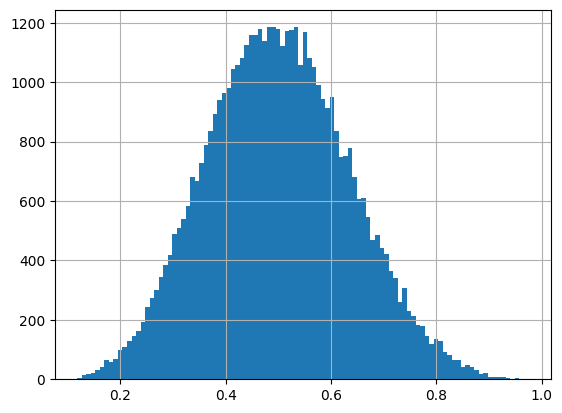

In [11]:
benchmark_importance_metrics_df['IMP_manh'].hist(bins=100)

### Plotting correlations

In [24]:
imp_metric_columns_map_dict = {
    'mentions_diff': 'Ment.',
    'sem_scholar_cit': 'Cit.',
    'ig': 'IG',
    'eig_cent_diff': 'EC',
    'betw_cent': 'BC',
    'jac_2nd_neg_train': 'JC2',
}

In [28]:
benchmark_imp_components_print_df = (
    benchmark_importance_metrics_df[imp_metric_columns]
        .rename(columns=imp_metric_columns_map_dict)
        .corr(method='spearman')
        .round(3)
)

In [29]:
benchmark_imp_components_print_df

,IG,EC,BC,JC2,Ment.,Cit.
IG,1.000,0.162,0.045,0.102,0.022,0.154
EC,0.162,1.000,0.032,-0.028,0.091,0.119
BC,0.045,0.032,1.000,-0.010,-0.001,0.014
JC2,0.102,-0.028,-0.010,1.000,-0.050,0.018
Ment.,0.022,0.091,-0.001,-0.050,1.000,0.476
Cit.,0.154,0.119,0.014,0.018,0.476,1.000


In [30]:
print(
    benchmark_imp_components_print_df.to_latex()
)

\begin{tabular}{lrrrrrr}
\toprule
{} &     IG &     EC &     BC &    JC2 &  Ment. &   Cit. \\
\midrule
IG    &  1.000 &  0.162 &  0.045 &  0.102 &  0.022 &  0.154 \\
EC    &  0.162 &  1.000 &  0.032 & -0.028 &  0.091 &  0.119 \\
BC    &  0.045 &  0.032 &  1.000 & -0.010 & -0.001 &  0.014 \\
JC2   &  0.102 & -0.028 & -0.010 &  1.000 & -0.050 &  0.018 \\
Ment. &  0.022 &  0.091 & -0.001 & -0.050 &  1.000 &  0.476 \\
Cit.  &  0.154 &  0.119 &  0.014 &  0.018 &  0.476 &  1.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_17961/1077251475.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  benchmark_imp_components_print_df.to_latex()


## Attaching models scores 

In [15]:
benchmark_model_scores_vs_imp_df = pd.merge(
    left=benchmark_importance_metrics_df,
    right=benchmark_models_scores_df[
        ['cui_pair'] + [c for c in benchmark_models_scores_df.columns if '_score' in c and 'w_st' not in c]
    ],
    how='inner'
).drop_duplicates()

In [18]:
benchmark_model_scores_vs_imp_df[imp_metric_columns].corr(method='spearman')

,mentions_diff,sem_scholar_cit,ig,eig_cent_diff,betw_cent,jac_2nd_neg_train
mentions_diff,1.000000,0.429749,-0.011590,0.067547,-0.015271,-0.092658
sem_scholar_cit,0.429749,1.000000,0.127735,0.114950,0.010789,-0.044091
ig,-0.011590,0.127735,1.000000,0.172625,0.048922,0.054599
eig_cent_diff,0.067547,0.114950,0.172625,1.000000,0.033147,-0.072637
betw_cent,-0.015271,0.010789,0.048922,0.033147,1.000000,-0.009716
jac_2nd_neg_train,-0.092658,-0.044091,0.054599,-0.072637,-0.009716,1.000000


In [15]:
benchmark_model_scores_vs_imp_df.to_pickle(
    '../benchmark_data/10_eval_ml_models/benchmark_model_scores_vs_imp_df.pkl'
)

### Transforming data into collections of pairs

In [13]:
diff_pos_neg_edges_cuis_dict = pd.read_pickle(
    '../benchmark_data/10_eval_ml_models/diff_pos_neg_edges_cuis_2016_2023_decaying_dict.pkl'
)

In [14]:
all_scores_decaying_df_dict = pd.read_pickle(
    '../benchmark_data/10_eval_ml_models/diff_pos_neg_edges_cuis_2016_2023_all_models_scores_dict.pkl'
)

In [15]:
pos_neg_pairs_df = diff_pos_neg_edges_cuis_dict[('2016', '2017')].copy()
all_scores_df = all_scores_decaying_df_dict[('2016', '2017')].copy()

In [16]:
pos_neg_pairs_df = pos_neg_pairs_df.reset_index().drop('index', axis=1)

In [17]:
pos_neg_pairs_df['group'] = pos_neg_pairs_df.index // 11 # 1pos + 10neg

In [18]:
pos_neg_pairs_df

,sem_pair,pair,label,group
0,"(Neoplastic Process, Pathologic Function)","(C0007102, C0267412)",1,0
1,"(Neoplastic Process, Pathologic Function)","(C0007102, C0151763)",0,0
2,"(Neoplastic Process, Pathologic Function)","(C0007102, C0333175)",0,0
3,"(Neoplastic Process, Pathologic Function)","(C0007102, C0456973)",0,0
4,"(Neoplastic Process, Pathologic Function)","(C0007102, C0339490)",0,0
...,...,...,...,...
336705,"(Neoplastic Process, Organ or Tissue Function)","(C0009402, C0597250)",0,30609
336706,"(Neoplastic Process, Organ or Tissue Function)","(C0009402, C1371668)",0,30609
336707,"(Neoplastic Process, Organ or Tissue Function)","(C0009402, C1160339)",0,30609
336708,"(Neoplastic Process, Organ or Tissue Function)","(C0009402, C0040445)",0,30609


In [19]:
pair_to_group_dict = (
    pos_neg_pairs_df[
        ['pair', 'group']
    ]
        .groupby('pair')
        .agg(set)
        ['group']
        .to_dict()
)

In [20]:
all_scores_df['group'] = all_scores_df['pair'].apply(lambda x: pair_to_group_dict.get(x))

In [21]:
all_scores_df = all_scores_df.explode('group')

In [22]:
len(all_scores_df)

339648

In [23]:
pairs_scores_df = all_scores_df[
    ['pair', 'label'] + [i for i in all_scores_df.columns if '_score' in i]
].groupby('pair').agg('mean')

In [24]:
pairs_scores_df.label.value_counts()

0.0    304640
1.0     30619
Name: label, dtype: int64

In [25]:
pairs_scores_df['group'] = pairs_scores_df.index.map(lambda x: pair_to_group_dict.get(x))

pairs_scores_df = pairs_scores_df.explode('group')

pairs_scores_df['label'] = pairs_scores_df['label'].astype(int)

grouped_dfs = {
    key: group.drop(columns='group') for key, group in tqdm(pairs_scores_df.groupby('group'))
}

pairs_scores_df_grouped_dict = dict()
for k, v_df in tqdm(grouped_dfs.items()):
    if len(v_df) == 11:
        cur_df = v_df
        pos_pair = cur_df[
            cur_df['label'] == 1
        ].index[0]
        pairs_scores_df_grouped_dict[pos_pair] = v_df

len(pairs_scores_df_grouped_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 30610/30610 [00:07<00:00, 3990.51it/s]


30610

In [26]:
pairs_scores_df_grouped_dict[('C0591573','C0072980')]

,label,ComplEx_w_st_score,ComplEx_wo_st_score,DistMult_w_st_score,DistMult_wo_st_score,HolE_w_st_score,HolE_wo_st_score,TransE_w_st_score,TransE_wo_st_score,agatha_2015_score,n2v_score
pair,,,,,,,,,,,
"(C0058177, C0591573)",0,-2.188680,-4.327767,-0.502729,-12.657372,-2.310918,-4.964293,-178.161285,-154.635406,0.412287,0.018813
"(C0059877, C0591573)",0,-1.593659,-9.584510,2.014294,-4.919772,-2.853305,-6.034155,-183.424835,-152.066345,0.508948,0.046550
"(C0060498, C0591573)",0,4.959142,5.487524,2.335593,-10.362339,3.709094,1.782822,-156.921143,-96.763512,0.517637,0.058954
"(C0061912, C0591573)",0,4.180757,-2.259794,0.686858,-8.140263,0.488364,0.940558,-146.755249,-109.469406,0.169170,0.011690
"(C0068458, C0591573)",0,6.444816,0.570420,2.350289,-6.365383,3.731397,2.287799,-149.614288,-104.771690,0.449851,0.031446
"(C0070394, C0591573)",0,-5.519112,-10.614468,-0.616333,-4.138231,-0.677707,-7.764649,-182.907410,-157.339066,0.383935,0.085097
"(C0148819, C0591573)",0,3.570989,-1.233294,1.427053,-8.247110,4.043015,-0.385426,-144.668945,-91.615891,0.196923,0.036376
"(C0591573, C0072980)",1,8.366026,5.781809,4.354687,0.265004,5.973384,2.837919,-137.365372,-101.571625,0.608353,0.912260
"(C0591573, C0612102)",0,-0.642287,-3.805256,0.891330,-9.169257,1.084350,-0.388056,-175.811340,-124.505280,0.272919,0.088618


## Plotting figures

In [27]:
benchmark_model_scores_vs_imp_df = pd.read_pickle(
    '../benchmark_data/10_eval_ml_models/benchmark_model_scores_vs_imp_df.pkl'
)

In [28]:
benchmark_model_scores_vs_imp_df

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent,jac_2nd_neg_train,IMP_manh,ComplEx_wo_st_score,DistMult_wo_st_score,HolE_wo_st_score,TransE_wo_st_score,agatha_2015_score,n2v_score
0,C0033308__progesterone,C1421999__SLC38A1 gene,C0033308,C1421999,C0033308 C1421999,1,27.0,0.005632,0.004669,0.345337,-1.701616e-03,0.000000e+00,-0.345337,0.437680,5.023353,-1.835982,3.740939,-60.999557,0.624519,0.341199
1,C0006142__Malignant neoplasm of breast,C1136328__Iridoids,C0006142,C1136328,C0006142 C1136328,2,48.0,0.006355,0.000272,0.028818,2.889029e-03,0.000000e+00,-0.028818,0.701774,6.580042,-1.888696,5.249362,-99.182281,0.661723,0.999994
2,C1412220__ADCY1 gene,C1419196__RAB27B gene,C1412220,C1419196,C1412220 C1419196,0,14.0,0.025336,0.013245,0.250526,-5.684694e-07,5.566458e-07,-0.250526,0.559032,1.862945,-7.084544,-1.497553,-49.785217,0.096406,0.119630
3,C1417530__MYD88 gene,C1418194__CLDN11 gene,C1417530,C1418194,C1417530 C1418194,1,27.0,0.011069,0.040462,0.555206,3.586332e-04,0.000000e+00,-0.555206,0.550642,0.530863,-9.412816,0.549673,-92.830521,0.072155,0.013100
4,C1332416__BIRC5 gene,"C1504635__TNFRSF10A protein, human",C1332416,C1504635,C1332416 C1504635,0,12.0,0.010392,0.129730,0.656319,-5.780687e-05,1.105265e-06,-0.656319,0.378560,1.032832,-2.736331,2.696989,-96.311646,0.620917,0.041700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18730,C0298130__montelukast,C0298619__LY 293111,C0298130,C0298619,C0298130 C0298619,0,12.0,0.009920,0.025875,0.393679,-2.309952e-05,1.503100e-06,-0.393679,0.472971,3.841303,-1.071695,2.148757,-111.957199,0.682829,0.323942
18731,C1414461__ESR1 gene,C1416377__IHH gene,C1414461,C1416377,C1414461 C1416377,0,51.0,0.002806,0.052830,0.591737,-1.564394e-04,4.081713e-09,-0.591737,0.379652,5.482594,-3.476025,2.776879,-76.423370,0.533202,0.003848
18732,C0036078__sulfasalazine,C0053230__benznidazole,C0036078,C0053230,C0036078 C0053230,0,34.0,0.002332,0.028751,0.364913,-6.452715e-05,0.000000e+00,-0.364913,0.383764,4.066293,1.323802,7.981551,-52.352264,0.759378,0.987353
18733,C0002335__alprostadil,C0008864__citrulline,C0002335,C0008864,C0002335 C0008864,0,14.0,0.000446,0.068027,0.512115,-1.114219e-04,5.522397e-08,-0.512115,0.314918,5.232498,3.641985,6.159329,-92.592293,0.817758,0.999923


### ROC AUC over different importance bins

In [29]:
bins_n = 3

In [30]:
linspace = np.linspace(0, 1, bins_n + 1)
linspace

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [31]:
quantiles_list = [
    benchmark_model_scores_vs_imp_df['IMP_manh'].quantile(q) for q in linspace
]

In [32]:
quantiles_list

[0.11856743809366936,
 0.4111137420157762,
 0.526807774666447,
 0.9255270960303079]

In [33]:
bin_assignment = np.digitize(benchmark_model_scores_vs_imp_df['IMP_manh'], quantiles_list, right=False)

In [34]:
set(bin_assignment), len(set(bin_assignment))

({1, 2, 3, 4}, 4)

In [35]:
benchmark_model_scores_vs_imp_df['bin_assignment'] = bin_assignment

In [83]:
benchmark_model_scores_vs_imp_df[['bin_assignment', 'IMP_manh']].groupby('bin_assignment').agg([min, max]).loc[range(1,bins_n+1)]['IMP_manh']

,min,max
bin_assignment,,
1,0.118567,0.411099
2,0.411121,0.526803
3,0.526818,0.922677


In [36]:
bin_assignment_dict = benchmark_model_scores_vs_imp_df['bin_assignment'].to_dict()

In [37]:
pair_to_manh_imp_dict = dict(
    zip(
        benchmark_model_scores_vs_imp_df['cui_pair'].apply(lambda x: tuple(x.split())),
        benchmark_model_scores_vs_imp_df['IMP_manh']
    )
)

In [38]:
bin_assignment_dict = dict(
    zip(
        benchmark_model_scores_vs_imp_df['cui_pair'].apply(lambda x: tuple(x.split())),
        benchmark_model_scores_vs_imp_df['bin_assignment']
    )
)

In [39]:
pairs_imp_grouped_dict = defaultdict(list)
for pair, pair_df in pairs_scores_df_grouped_dict.items():
    if pair in pair_to_manh_imp_dict:
        imp_score_bin = bin_assignment_dict[pair]
        if imp_score_bin > bins_n:
            imp_score_bin = bins_n
        pair_df['IMP_manh'] = pair_to_manh_imp_dict[pair]
        pairs_imp_grouped_dict[imp_score_bin].append(pair_df)

In [40]:
{k:len(v) for k,v in pairs_imp_grouped_dict.items()}

{1: 6245, 2: 6245, 3: 6245}

In [41]:
for k,v in pairs_imp_grouped_dict.items():
    pairs_imp_grouped_dict[k] = pd.concat(v)

In [42]:
pairs_imp_grouped_dict = dict(pairs_imp_grouped_dict)

In [43]:
score_cols_df_list = [
    col for col in benchmark_model_scores_vs_imp_df.columns if '_score' in col
]

In [44]:
score_cols_df_list

['ComplEx_wo_st_score',
 'DistMult_wo_st_score',
 'HolE_wo_st_score',
 'TransE_wo_st_score',
 'agatha_2015_score',
 'n2v_score']

In [45]:
roc_auc_scores_dict = defaultdict(dict)

for imp_bin in tqdm(sorted(pairs_imp_grouped_dict)):
    
    if imp_bin <= bins_n:
    
        for model_col in score_cols_df_list:

            cur_roc_auc_score = roc_auc_score(
                y_true=pairs_imp_grouped_dict[imp_bin]['label'],
                y_score=pairs_imp_grouped_dict[imp_bin][model_col],
            )
            
            imp_label = f''
            roc_auc_scores_dict[f'imp_bin_{imp_bin}'][model_col] = cur_roc_auc_score

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.17it/s]


In [46]:
roc_auc_scores_over_imp_bins_df = pd.DataFrame(roc_auc_scores_dict).T

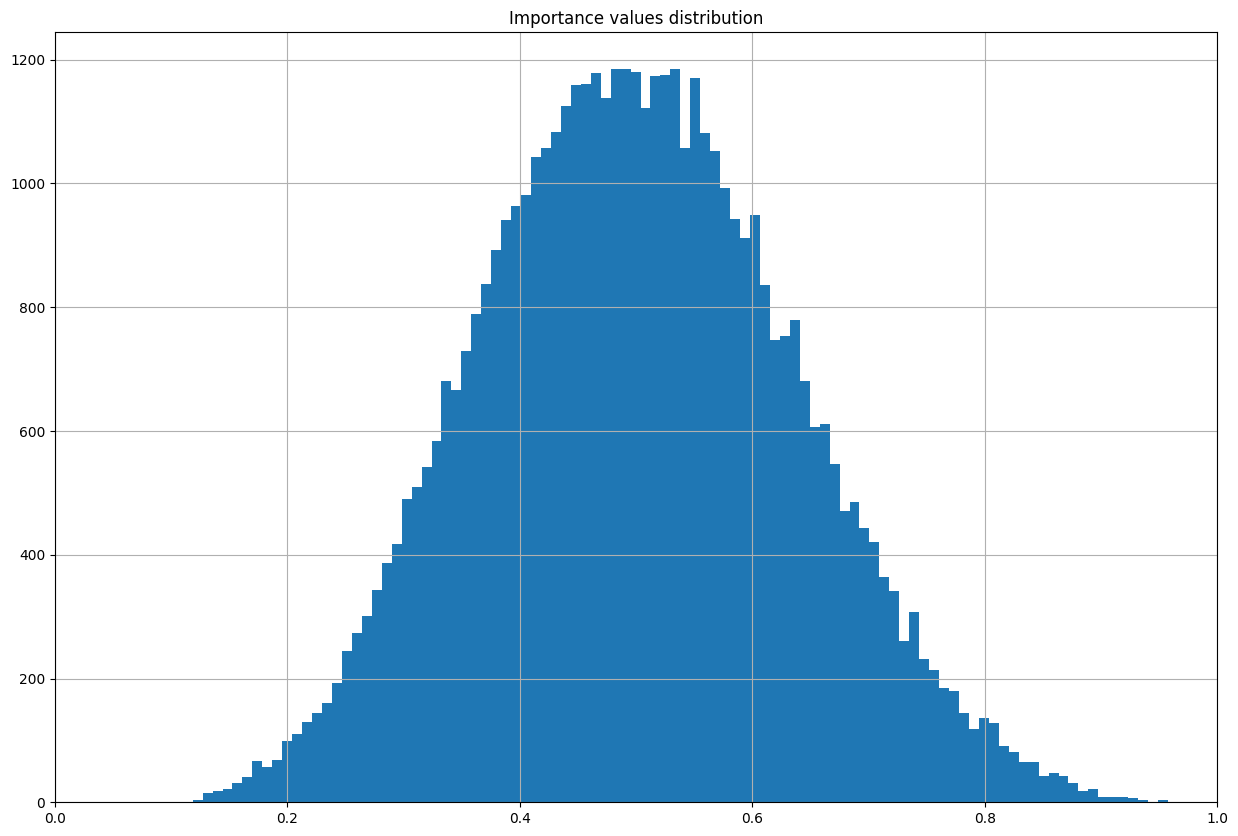

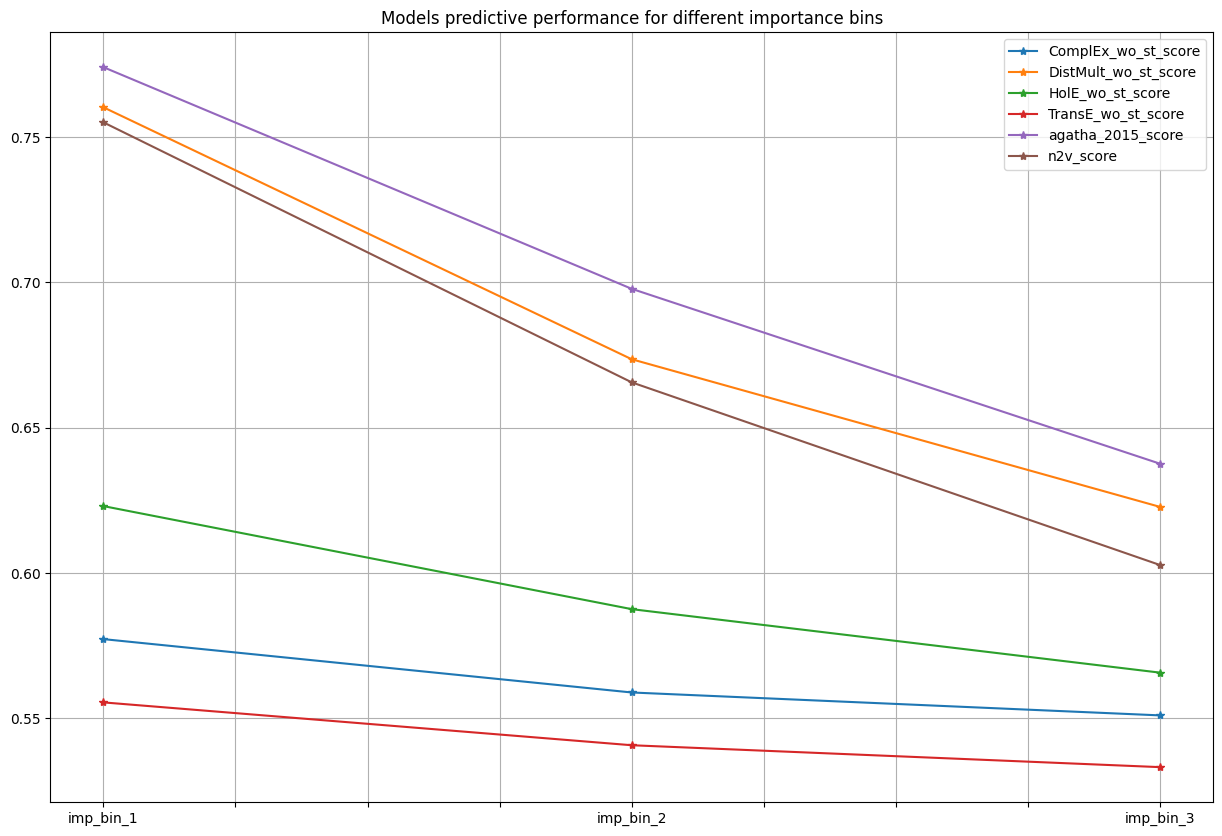

In [47]:
benchmark_importance_metrics_df['IMP_manh'].hist(bins=100, figsize=(15,10))
plt.title('Importance values distribution')
plt.xlim(0,1)

roc_auc_scores_over_imp_bins_df[score_cols_df_list].plot(
    style='-*',
    figsize=(15,10),
    #x='bin_coord'
)
# Add vertical lines for each percentile
#for p, val in zip(range(10, 100, 10), quantiles_list[:]):
#    plt.axvline(val, color='r', linestyle='dashed', linewidth=1)
#    plt.text(val, 0.02, f'{p}%', rotation=90, verticalalignment='bottom', horizontalalignment='right', color='r')
plt.title('Models predictive performance for different importance bins')
plt.grid('minor')
#plt.xlim(0,1)

In [62]:
roc_auc_scores_over_imp_bins_df

,ComplEx_wo_st_score,DistMult_wo_st_score,HolE_wo_st_score,TransE_wo_st_score,agatha_2015_score,n2v_score
imp_bin_1,0.577234,0.760260,0.623015,0.555459,0.774067,0.755081
imp_bin_2,0.558869,0.673543,0.587546,0.540715,0.697777,0.665592
imp_bin_3,0.550985,0.622725,0.565692,0.533178,0.637583,0.602722


In [84]:
bins_vals_df = (
    benchmark_model_scores_vs_imp_df[['bin_assignment', 'IMP_manh']]
        .groupby('bin_assignment')
        .agg([min, max])
        .loc[range(1,bins_n+1)]['IMP_manh']
)

In [88]:
bins_vals_df

,min,max
bin_assignment,,
1,0.118567,0.411099
2,0.411121,0.526803
3,0.526818,0.922677


In [197]:
plot_roc_auc_scores_over_imp_bins_df = (
    roc_auc_scores_over_imp_bins_df
    .rename(
        columns = {
            'agatha_2015_score': 'AGATHA',
            'DistMult_wo_st_score': 'DistMult',
            'n2v_score': 'Node2Vec',
            'HolE_wo_st_score': 'HolE',
            'ComplEx_wo_st_score': 'ComplEx',
            'TransE_wo_st_score': 'TransE',
        }
    )
    .T.rename(
        columns = {
            'imp_bin_1': f"Low importance\n( < {round(bins_vals_df.loc[1]['max'], 2)})",
            'imp_bin_2': f"Medium importance\n({round(bins_vals_df.loc[2]['min'], 2)} $\leq$ $I_t$ $\leq$ {round(bins_vals_df.loc[2]['max'], 2)})",
            'imp_bin_3': f"High importance\n( > {round(bins_vals_df.loc[3]['min'], 2)})",
        }
    ).T
)

In [198]:
plot_score_cols_df_list = list(plot_roc_auc_scores_over_imp_bins_df.iloc[-1].sort_values(ascending=False).index)

In [199]:
plot_roc_auc_scores_over_imp_bins_df = plot_roc_auc_scores_over_imp_bins_df[plot_score_cols_df_list]

In [200]:
plot_roc_auc_scores_over_imp_bins_df

,AGATHA,DistMult,Node2Vec,HolE,ComplEx,TransE
Low importance\n( < 0.41),0.774067,0.760260,0.755081,0.623015,0.577234,0.555459
Medium importance\n(0.41 $\leq$ $I_t$ $\leq$ 0.53),0.697777,0.673543,0.665592,0.587546,0.558869,0.540715
High importance\n( > 0.53),0.637583,0.622725,0.602722,0.565692,0.550985,0.533178


In [201]:
plot_roc_auc_scores_over_imp_bins_df.to_csv('saved_figures/plot_roc_auc_scores_over_imp_bins_df.csv')

In [202]:
def plot_bar_line_combo(df: pd.DataFrame):
    """
    Function to plot a combined bar and line chart from a dataframe.
    
    Parameters:
    - df: pandas DataFrame with index as categories and columns as different series
    
    Returns:
    - ax: The matplotlib axes object with the plot.
    """
    
    plt.rcParams.update({'font.size': 20})
    # Set up the matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(15, 10))

    # Number of bars (series) and bar groups (categories)
    n_bars = len(df.columns)
    n_groups = len(df.index)

    # The x location for the groups and the width of each bar
    bar_inds = np.arange(n_groups)
    bar_width = 0.9 / n_bars

    # Plotting the bars
    for i, column in enumerate(df.columns):
        ax.bar(bar_inds + i * bar_width, df[column], width=bar_width, label=column, alpha=0.4)

    # Plotting the line plots
    for i, column in enumerate(df.columns):
        # The x position for the line plot is the center of the bar
        line_x_positions = bar_inds + i * bar_width # + bar_width / 2
        ax.plot(
            line_x_positions,
            df[column],
            marker='o',
            linestyle='-',
            linewidth=2,
            alpha=0.5
        )

    # Set the positions of the x-ticks to be in the center of the groups
    ax.set_xticks(bar_inds + bar_width * n_bars / 2 - bar_width / 2)
    ax.set_xticklabels(df.index)

    # Other plot settings
    ax.set_ylim(0.5, 0.8)
    ax.set_ylabel('ROC AUC Score')
    ax.set_title('Models Evaluation with Importance-based Stratification')
    ax.legend()
    
    plt.savefig('saved_figures/eval_imp_strat.pdf', bbox_inches='tight')

    # Return the axes object with the plot
    return ax



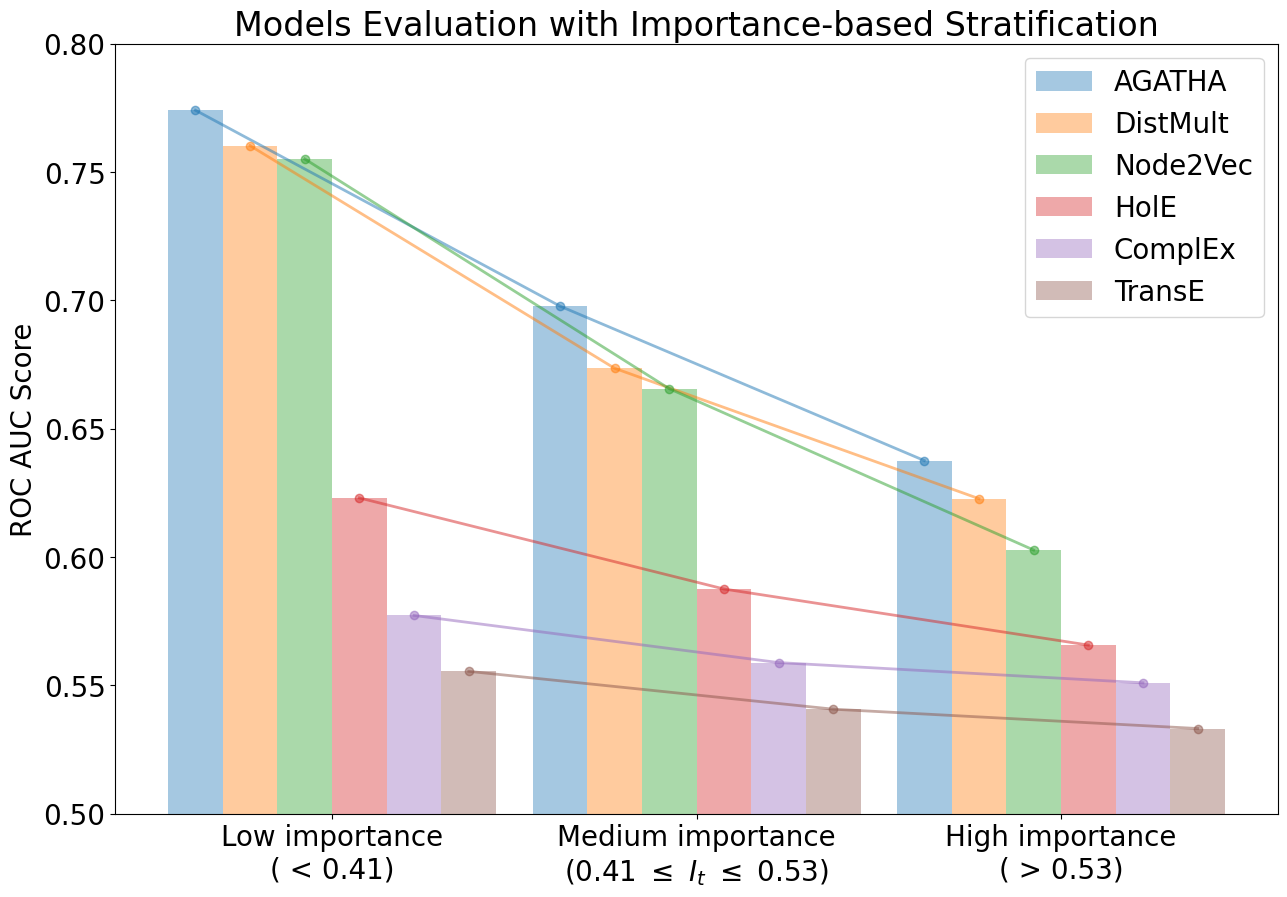

In [203]:

# We'll use the previously created DataFrame `df` to run the function.
combo_plot = plot_bar_line_combo(plot_roc_auc_scores_over_imp_bins_df)
plt.show()

## Adding info to importance table

In [ ]:
benchmark_importance_metrics_df.to_csv('../benchmark_data/benchmark_pos_pairs_importance_test2016_imp2022_df.csv')

In [10]:
benchmark_importance_metrics_df

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent,jac_2nd_neg_train,IMP_manh
0,C0033308__progesterone,C1421999__SLC38A1 gene,C0033308,C1421999,C0033308 C1421999,1,27.0,0.005632,0.004669,0.345337,-0.001702,0.000000e+00,-0.345337,0.437680
1,C0557874__Global developmental delay,C0152423__Congenital small ears,C0557874,C0152423,C0152423 C0557874,1,39.0,0.006297,0.105121,0.542392,0.000053,9.112312e-09,-0.542392,0.582247
2,C1332733__CDK2 gene,C1332650__C-Terminal Binding Protein 1,C1332733,C1332650,C1332650 C1332733,1,6.0,0.016198,0.049270,0.600761,-0.000063,1.621441e-06,-0.600761,0.469042
3,C0006142__Malignant neoplasm of breast,C1136328__Iridoids,C0006142,C1136328,C0006142 C1136328,2,48.0,0.006355,0.000272,0.028818,0.002889,0.000000e+00,-0.028818,0.701774
4,C1456409__etravirine,C4045491__doravirine,C1456409,C4045491,C1456409 C4045491,15,239.0,0.016966,0.030973,0.140814,-0.000003,1.250633e-06,-0.140814,0.788580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48563,"C1448177__TNF protein, human",C1824798__CRTC1 gene,C1448177,C1824798,C1448177 C1824798,1,64.0,0.008860,0.011995,0.405616,0.004581,0.000000e+00,-0.405616,0.649974
48564,C1332803__CTNNB1 gene,C1835953__NOTUM gene,C1332803,C1835953,C1332803 C1835953,4,147.0,0.031855,0.013270,0.105266,0.000367,1.700016e-06,-0.105266,0.876397
48565,C0002335__alprostadil,C0008864__citrulline,C0002335,C0008864,C0002335 C0008864,0,14.0,0.000446,0.068027,0.512115,-0.000111,5.522397e-08,-0.512115,0.314918
48566,C1363984__TNFRSF1A gene,C2350562__Brominated Diphenyl Ethers,C1363984,C2350562,C1363984 C2350562,0,4.0,0.002455,0.010173,0.334290,-0.000046,1.520694e-05,-0.334290,0.435436


### Semantic types

In [11]:
cui_to_semtype_dict = pd.read_pickle(
    '../UMLS_Metathesaurus/CUI_to_semtype_2022AA_dict.pkl'
)

In [13]:
cui_to_semtype_dict['C0000005']

{'Amino Acid, Peptide, or Protein',
 'Indicator, Reagent, or Diagnostic Aid',
 'Pharmacologic Substance'}

In [21]:
benchmark_importance_metrics_df['source_st'] = (
    benchmark_importance_metrics_df['source_cui'].apply(
        lambda x: '; '.join(list(cui_to_semtype_dict.get(x))) if x in cui_to_semtype_dict else None
    )
)

benchmark_importance_metrics_df['target_st'] = (
    benchmark_importance_metrics_df['target_cui'].apply(
        lambda x: '; '.join(list(cui_to_semtype_dict.get(x))) if x in cui_to_semtype_dict else None
    )
)

In [22]:
benchmark_importance_metrics_df[
    benchmark_importance_metrics_df['target_st'].isna()
]

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent,jac_2nd_neg_train,IMP_manh,source_st,target_st
1101,C0007102__Malignant tumor of colon,C1837991__,C0007102,C1837991,C0007102 C1837991,0,158.0,0.006455,0.003218,0.063264,-0.002838,0.000000e+00,-0.063264,0.487054,Neoplastic Process,None
2227,C1335879__STIM1 gene,C0494261__,C1335879,C0494261,C0494261 C1335879,5,282.0,0.010392,0.007663,0.359087,0.000034,0.000000e+00,-0.359087,0.697603,Gene or Genome,None
4895,C0525045__Mood Disorders,C0005001__,C0525045,C0005001,C0005001 C0525045,1,132.0,-0.000377,0.032140,0.283060,0.000135,0.000000e+00,-0.283060,0.579716,Mental or Behavioral Dysfunction,None
11680,C0242379__Malignant neoplasm of lung,C0431350__,C0242379,C0431350,C0242379 C0431350,0,14.0,0.002251,0.006596,0.197022,0.007060,0.000000e+00,-0.197022,0.481914,Neoplastic Process,None
12018,C0023890__Liver Cirrhosis,C0494261__,C0023890,C0494261,C0023890 C0494261,0,11.0,0.003901,0.035647,0.341602,-0.000397,0.000000e+00,-0.341602,0.319717,Disease or Syndrome,None
18663,C0007194__Hypertrophic Cardiomyopathy,C0494261__,C0007194,C0494261,C0007194 C0494261,1,15.0,0.005205,0.027422,0.377310,-0.000024,0.000000e+00,-0.377310,0.445636,Disease or Syndrome,None
21414,C0006142__Malignant neoplasm of breast,C0494261__,C0006142,C0494261,C0006142 C0494261,0,7.0,0.003226,0.018459,0.300082,0.002853,0.000000e+00,-0.300082,0.446973,Neoplastic Process,None
27832,C0004352__Autistic Disorder,C0005001__,C0004352,C0005001,C0004352 C0005001,0,36.0,-0.000654,0.014503,0.280810,0.000597,4.520352e-08,-0.280810,0.532997,Mental or Behavioral Dysfunction,None
32950,C1535926__Neurodevelopmental Disorders,C0494261__,C1535926,C0494261,C0494261 C1535926,1,53.0,0.004316,0.045226,0.438794,0.000313,0.000000e+00,-0.438794,0.578304,Mental or Behavioral Dysfunction,None
39681,C0001418__Adenocarcinoma,C0431350__,C0001418,C0431350,C0001418 C0431350,0,14.0,0.002084,0.007246,0.212344,-0.007216,0.000000e+00,-0.212344,0.311946,Neoplastic Process,None


In [23]:
benchmark_importance_metrics_df

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent,jac_2nd_neg_train,IMP_manh,source_st,target_st
0,C0033308__progesterone,C1421999__SLC38A1 gene,C0033308,C1421999,C0033308 C1421999,1,27.0,0.005632,0.004669,0.345337,-0.001702,0.000000e+00,-0.345337,0.437680,Pharmacologic Substance; Organic Chemical; Hor...,Gene or Genome
1,C0557874__Global developmental delay,C0152423__Congenital small ears,C0557874,C0152423,C0152423 C0557874,1,39.0,0.006297,0.105121,0.542392,0.000053,9.112312e-09,-0.542392,0.582247,Mental or Behavioral Dysfunction,Congenital Abnormality
2,C1332733__CDK2 gene,C1332650__C-Terminal Binding Protein 1,C1332733,C1332650,C1332650 C1332733,1,6.0,0.016198,0.049270,0.600761,-0.000063,1.621441e-06,-0.600761,0.469042,Gene or Genome,"Amino Acid, Peptide, or Protein; Biologically ..."
3,C0006142__Malignant neoplasm of breast,C1136328__Iridoids,C0006142,C1136328,C0006142 C1136328,2,48.0,0.006355,0.000272,0.028818,0.002889,0.000000e+00,-0.028818,0.701774,Neoplastic Process,Organic Chemical
4,C1456409__etravirine,C4045491__doravirine,C1456409,C4045491,C1456409 C4045491,15,239.0,0.016966,0.030973,0.140814,-0.000003,1.250633e-06,-0.140814,0.788580,Pharmacologic Substance; Organic Chemical,Pharmacologic Substance; Organic Chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48563,"C1448177__TNF protein, human",C1824798__CRTC1 gene,C1448177,C1824798,C1448177 C1824798,1,64.0,0.008860,0.011995,0.405616,0.004581,0.000000e+00,-0.405616,0.649974,"Amino Acid, Peptide, or Protein; Biologically ...",Gene or Genome
48564,C1332803__CTNNB1 gene,C1835953__NOTUM gene,C1332803,C1835953,C1332803 C1835953,4,147.0,0.031855,0.013270,0.105266,0.000367,1.700016e-06,-0.105266,0.876397,Gene or Genome,Gene or Genome
48565,C0002335__alprostadil,C0008864__citrulline,C0002335,C0008864,C0002335 C0008864,0,14.0,0.000446,0.068027,0.512115,-0.000111,5.522397e-08,-0.512115,0.314918,Pharmacologic Substance; Organic Chemical,"Amino Acid, Peptide, or Protein; Pharmacologic..."
48566,C1363984__TNFRSF1A gene,C2350562__Brominated Diphenyl Ethers,C1363984,C2350562,C1363984 C2350562,0,4.0,0.002455,0.010173,0.334290,-0.000046,1.520694e-05,-0.334290,0.435436,Gene or Genome,Organic Chemical; Hazardous or Poisonous Subst...


### Source DB

Attaching source database for every connection.

In [71]:
json_pairs_path = Path(
    '../benchmark_data/01_cui_pairs_json/'
)

json_pairs_flist = sorted(json_pairs_path.glob('*.json'))

In [72]:
json_pairs_flist = [fn for fn in json_pairs_flist]

In [75]:
json_pairs_flist

[PosixPath('../benchmark_data/01_cui_pairs_json/ctd_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/disgennet_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/drugcentral_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/gwas_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/kegg_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/mentha_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/rxnav_cui_pairs.json'),
 PosixPath('../benchmark_data/01_cui_pairs_json/stringdb_cui_pairs.json')]

In [76]:
db_pair_to_source_dict = defaultdict(set)

for fname in tqdm(json_pairs_flist):
    with open(fname, 'r') as f:
        cur_pairs_list = json.load(f)
        prefix = fname.stem.split('_')[0]
    
    for pair in cur_pairs_list:
        pair = sorted(pair)
        pair_str = ' '.join(pair)
        #pair_inv_str = ' '.join(reversed(pair))
        db_pair_to_source_dict[pair_str].add(prefix)
        #db_pair_to_source_dict[pair_inv_str].add(prefix)

100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [02:17<00:00, 17.24s/it]


In [77]:
len(db_pair_to_source_dict)

50451953

In [83]:
benchmark_importance_metrics_df['origin_db'] = (
    benchmark_importance_metrics_df['cui_pair'].apply(
        lambda x: '; '.join(sorted(db_pair_to_source_dict.get(x)))
    )
)

In [84]:
benchmark_importance_metrics_df[
    benchmark_importance_metrics_df['origin_db'].isna()
]

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent,jac_2nd_neg_train,IMP_manh,source_st,target_st,Origin_DB,origin_db


In [90]:
benchmark_importance_metrics_df['origin_db'].value_counts()

kegg                      19944
ctd                       10085
drugcentral                4516
disgennet                  4035
rxnav                      3009
gwas                       1218
kegg; stringdb              996
mentha                      893
ctd; disgennet              804
kegg; rxnav                 710
stringdb                    690
ctd; kegg                   586
ctd; drugcentral            253
kegg; mentha; stringdb      229
kegg; mentha                215
drugcentral; kegg           133
mentha; stringdb            123
ctd; drugcentral; kegg       68
ctd; disgennet; gwas         43
ctd; disgennet; kegg          5
disgennet; gwas               5
ctd; rxnav                    3
ctd; gwas                     3
gwas; kegg                    1
disgennet; kegg               1
Name: origin_db, dtype: int64

In [91]:
benchmark_importance_metrics_df[
    benchmark_importance_metrics_df['origin_db'] == 'disgennet; kegg'
]

,source,target,source_cui,target_cui,cui_pair,mentions_diff,sem_scholar_cit,ig,jac_1st_train,jac_2nd_train,eig_cent_diff,betw_cent,jac_2nd_neg_train,IMP_manh,source_st,target_st,origin_db
39664,C0004096__Asthma,"C1667077__CCL11 protein, human",C0004096,C1667077,C0004096 C1667077,2,18.0,0.021426,0.004702,0.15922,-0.00207,0.0,-0.15922,0.528134,Disease or Syndrome,"Amino Acid, Peptide, or Protein; Biologically ...",disgennet; kegg
